<a href="https://colab.research.google.com/github/gcosma/ConceptAnnotationPfD/blob/main/Final16Nov2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Label Concept Annotation - COMPLETE IMPROVED VERSION
## Fine-tuned BERT for Healthcare Safety Theme Classification

**🎯 Optimized for 21-27 Class Problems with Class Imbalance**

### Key Features:
- ✅ Enhanced data augmentation with targeted fixes for struggling classes
- ✅ Class weights for imbalanced data
- ✅ 9 BERT model options (PathologyBERT, Bio-ClinicalBERT, etc.)
- ✅ Improved training configuration (cosine scheduling, macro F1 optimization)
- ✅ Extended sequence length (512 tokens)
- ✅ Comprehensive error analysis and diagnostics
- ✅ Handles test sets with missing labels
- ✅ Two-stage training for difficult classes

### Expected Performance:
- Baseline: ~67% accuracy
- With improvements: 70-75% accuracy

## 1. Install Required Libraries

In [3]:
!pip install -q transformers datasets torch scikit-learn pandas numpy accelerate imbalanced-learn

## 2. Import Libraries and Setup

In [4]:
import pandas as pd
import numpy as np
import torch
import re
import random
from typing import List, Dict
from collections import Counter

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✓ Libraries imported successfully")

Using device: cuda
✓ Libraries imported successfully


## 3. Upload Your Training and Testing CSV Files

In [5]:
from google.colab import files

print("Upload your TRAINING CSV file:")
uploaded_train = files.upload()
train_filename = list(uploaded_train.keys())[0]
print(f"✓ Training file uploaded: {train_filename}")

print("\nUpload your TESTING CSV file:")
uploaded_test = files.upload()
test_filename = list(uploaded_test.keys())[0]
print(f"✓ Testing file uploaded: {test_filename}")

Upload your TRAINING CSV file:


Saving Training Iteration 2.csv to Training Iteration 2.csv
✓ Training file uploaded: Training Iteration 2.csv

Upload your TESTING CSV file:


Saving Testing Iteration 2.csv to Testing Iteration 2.csv
✓ Testing file uploaded: Testing Iteration 2.csv


## 4. Load and Clean Data (IMPROVED)

In [ ]:
def load_csv_with_encoding(filename):
    """Try multiple encodings to load CSV file"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']

    for encoding in encodings:
        try:
            df = pd.read_csv(filename, encoding=encoding)
            print(f"✓ Loaded with {encoding} encoding")
            return df
        except UnicodeDecodeError:
            continue

    print("Using latin-1 encoding with error handling")
    return pd.read_csv(filename, encoding='latin-1', errors='replace')

def clean_text(text):
    """Clean text by replacing encoding artifacts"""
    if pd.isna(text):
        return ""

    text = str(text)

    # Replace common Windows-1252 encoding artifacts
    replacements = {
        '\x91': "'", '\x92': "'", '\x93': '"', '\x94': '"',
        '\x96': '-', '\x97': '-', '\x85': '...', '\x95': '*',
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def standardize_label(label):
    """Standardize label formatting to prevent duplicates"""
    if pd.isna(label):
        return ""
    label = str(label)
    # Consistent dash spacing: "Word - Word" becomes "Word- Word"
    label = re.sub(r'\s*-\s*', '- ', label)
    # Single spaces only
    label = re.sub(r'\s+', ' ', label)
    return label.strip()

# Load and clean data
print("Loading training data...")
train_df = load_csv_with_encoding(train_filename)
train_df['Text'] = train_df['Text'].apply(clean_text)
train_df['Label'] = train_df['Label'].apply(clean_text).apply(standardize_label)
train_df = train_df[(train_df['Text'] != '') & (train_df['Label'] != '')].reset_index(drop=True)

print("\nLoading testing data...")
test_df = load_csv_with_encoding(test_filename)
test_df['Text'] = test_df['Text'].apply(clean_text)
test_df['Label'] = test_df['Label'].apply(clean_text).apply(standardize_label)
test_df = test_df[(test_df['Text'] != '') & (test_df['Label'] != '')].reset_index(drop=True)

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print("\n✓ Data loaded, cleaned, and labels standardized")

## 5. Explore Label Distribution and Identify Issues

In [ ]:
# Get all unique labels from training data
all_labels = sorted(train_df['Label'].unique().tolist())
num_labels = len(all_labels)

print(f"Total unique concept labels: {num_labels}\n")
print("Label distribution in training data:")
print("=" * 80)
label_counts = train_df['Label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"{label}: {count} ({percentage:.1f}%)")

# Identify minority classes (less than 5% of data)
threshold = len(train_df) * 0.05
minority_classes = label_counts[label_counts < threshold].index.tolist()

print(f"\n⚠ Minority classes (< 5% of data): {len(minority_classes)}")
for label in minority_classes:
    print(f"  - {label}: {label_counts[label]} samples")

# Identify very small classes (these will likely struggle)
median_count = label_counts.median()
very_small_classes = label_counts[label_counts < median_count * 0.5].index.tolist()

print(f"\n⚠️ VERY SMALL classes (< 50% of median): {len(very_small_classes)}")
print("   These classes will need aggressive augmentation:")
for label in very_small_classes:
    print(f"  - {label}: {label_counts[label]} samples")

# Create label mappings
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for idx, label in enumerate(all_labels)}

print("\n✓ Label analysis complete")

## 5b. Keyword Analysis for Understanding Classes (NEW)

In [ ]:
def extract_keywords(texts, top_n=10):
    """Extract most common meaningful words from texts"""
    # Common stopwords to ignore
    stopwords = {'that', 'this', 'with', 'from', 'were', 'been', 'have',
                 'there', 'their', 'would', 'could', 'should', 'about'}

    all_words = []
    for text in texts:
        # Extract words 4+ characters
        words = re.findall(r'\b[a-z]{4,}\b', text.lower())
        words = [w for w in words if w not in stopwords]
        all_words.extend(words)

    return Counter(all_words).most_common(top_n)

print("\n" + "="*80)
print("KEYWORD ANALYSIS FOR SMALL CLASSES")
print("="*80)
print("Understanding what distinguishes each class...\n")

for label in very_small_classes[:5]:  # Show first 5 small classes
    label_texts = train_df[train_df['Label'] == label]['Text'].tolist()
    keywords = extract_keywords(label_texts, top_n=8)

    print(f"\n{label}:")
    print(f"  Sample size: {len(label_texts)}")
    print(f"  Key terms: {', '.join([f'{word}({count})' for word, count in keywords[:5]])}")
    if label_texts:
        print(f"  Example: '{label_texts[0][:120]}...'")

print("\n✓ Keyword analysis complete")

## 6. Enhanced Data Augmentation (IMPROVED)

In [ ]:
def augment_sentence_enhanced(sentence):
    """
    ENHANCED augmentation with more synonyms and strategies
    """
    replacements = {
        # Negations and failures
        'did not': ['failed to', 'neglected to', 'omitted to', 'did not manage to'],
        'was not': ['failed to be', 'wasn\'t', 'proved not to be'],
        'were not': ['failed to be', 'weren\'t', 'proved not to be'],
        'no ': ['absence of ', 'lacking ', 'without ', 'zero '],
        'not ': ['never ', 'insufficiently ', 'inadequately '],

        # Deficiencies
        'lack of': ['absence of', 'insufficient', 'inadequate', 'deficiency in', 'shortage of'],
        'poor': ['inadequate', 'insufficient', 'substandard', 'deficient', 'weak'],
        'limited': ['restricted', 'constrained', 'insufficient', 'minimal'],

        # Time and delays
        'delay': ['postponement', 'holdup', 'lag', 'wait', 'deferment'],
        'delayed': ['postponed', 'held up', 'deferred', 'put off'],

        # People and roles
        'staff': ['personnel', 'workers', 'employees', 'clinicians', 'team members', 'professionals'],
        'patient': ['individual', 'service user', 'person', 'case'],
        'doctor': ['physician', 'clinician', 'medical practitioner', 'consultant'],
        'nurse': ['nursing staff', 'clinical nurse', 'healthcare professional'],

        # Actions and processes
        'training': ['education', 'instruction', 'preparation', 'development', 'teaching'],
        'communication': ['information sharing', 'dialogue', 'correspondence', 'liaison', 'discussion'],
        'assessment': ['evaluation', 'review', 'examination', 'appraisal', 'analysis'],
        'procedure': ['process', 'protocol', 'guideline', 'pathway', 'method'],
        'treatment': ['intervention', 'care', 'therapy', 'management'],

        # Places and systems
        'hospital': ['healthcare facility', 'medical centre', 'trust', 'ward'],
        'department': ['unit', 'service', 'team', 'division'],

        # Documentation
        'record': ['documentation', 'note', 'file', 'entry', 'report'],
        'documented': ['recorded', 'noted', 'logged', 'written'],

        # Problems and issues
        'error': ['mistake', 'oversight', 'lapse', 'failing', 'slip'],
        'issue': ['concern', 'problem', 'matter', 'challenge', 'difficulty'],
        'failure': ['breakdown', 'malfunction', 'collapse', 'shortcoming'],
        'risk': ['danger', 'hazard', 'threat', 'concern'],
    }

    variations = []
    sentence_lower = sentence.lower()

    # Strategy 1: Synonym replacement
    for orig, syns in replacements.items():
        if orig in sentence_lower:
            for syn in syns[:3]:  # Use top 3 synonyms
                pattern = re.compile(re.escape(orig), re.IGNORECASE)
                new_sent = pattern.sub(syn, sentence, count=1)
                if new_sent != sentence and len(new_sent) > 10:
                    variations.append(new_sent)

    # Strategy 2: Add context phrases (helps model learn structure)
    if variations and random.random() > 0.7:  # 30% of the time
        prefixes = [
            "The investigation found that ",
            "It was noted that ",
            "The report identified that ",
            "Evidence showed that "
        ]
        variations.append(random.choice(prefixes) + sentence.lower())

    return variations


print("="*80)
print("ENHANCED DATA AUGMENTATION FOR CLASS IMBALANCE")
print("="*80)

# Determine augmentation strategy
augmented_texts = []
augmented_labels = []

# Add all original samples
for idx, row in train_df.iterrows():
    augmented_texts.append(row['Text'])
    augmented_labels.append(row['Label'])

# Standard augmentation: bring classes up to median
augmentation_count = 0
for label in all_labels:
    label_count = label_counts.get(label, 0)

    if label_count < median_count:
        label_samples = train_df[train_df['Label'] == label]['Text'].tolist()
        target_count = int(median_count)
        augmentations_needed = target_count - label_count

        for _ in range(augmentations_needed):
            sample = random.choice(label_samples)
            variations = augment_sentence_enhanced(sample)

            if variations:
                augmented_text = random.choice(variations)
                augmented_texts.append(augmented_text)
                augmented_labels.append(label)
                augmentation_count += 1

print(f"\nStandard augmentation complete:")
print(f"  Original: {len(train_df)}")
print(f"  Added: {augmentation_count}")
print(f"  Total: {len(augmented_texts)}")

# TARGETED SUPER-AUGMENTATION for very small classes
print("\n" + "="*80)
print("TARGETED SUPER-AUGMENTATION FOR STRUGGLING CLASSES")
print("="*80)

extra_augmentation_count = 0
for label in very_small_classes:
    current_count = sum(1 for l in augmented_labels if l == label)
    target_count = int(median_count * 1.5)  # 1.5x median for struggling classes

    if current_count < target_count:
        label_samples = train_df[train_df['Label'] == label]['Text'].tolist()
        additional_needed = target_count - current_count

        print(f"\n{label}:")
        print(f"  Current: {current_count} → Target: {target_count}")
        print(f"  Adding: {additional_needed} extra samples")

        for _ in range(additional_needed):
            sample = random.choice(label_samples)
            variations = augment_sentence_enhanced(sample)

            if variations:
                augmented_text = random.choice(variations)
            else:
                # If no variations, make small modification
                augmented_text = sample.rstrip('.') + '.'

            augmented_texts.append(augmented_text)
            augmented_labels.append(label)
            extra_augmentation_count += 1

print(f"\nSuper-augmentation complete: +{extra_augmentation_count} samples")

# Create final augmented dataframe
train_df_augmented = pd.DataFrame({
    'Text': augmented_texts,
    'Label': augmented_labels
})

print("\n" + "="*80)
print("FINAL AUGMENTATION SUMMARY")
print("="*80)
print(f"Original training size: {len(train_df)}")
print(f"Standard augmentation: +{augmentation_count}")
print(f"Super-augmentation: +{extra_augmentation_count}")
print(f"FINAL training size: {len(train_df_augmented)}")
print(f"Increase: {(len(train_df_augmented)/len(train_df) - 1)*100:.1f}%")

# Show distribution after augmentation
print("\nLabel distribution after ALL augmentation:")
aug_label_counts = train_df_augmented['Label'].value_counts()
print(f"  Min: {aug_label_counts.min()} | Median: {aug_label_counts.median():.0f} | Max: {aug_label_counts.max()}")

print("\n✓ Enhanced data augmentation complete")

## 7. Calculate Class Weights

In [ ]:
# Convert labels to IDs in augmented dataset
train_df_augmented['label_id'] = train_df_augmented['Label'].map(label2id)

# Calculate class weights for remaining imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(range(num_labels)),
    y=train_df_augmented['label_id'].values
)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights computed:")
print("="*80)
weight_df = pd.DataFrame({
    'Label': all_labels,
    'Weight': class_weights,
    'Count': [aug_label_counts.get(label, 0) for label in all_labels]
}).sort_values('Weight', ascending=False)

print("Top 10 highest weighted classes (most underrepresented):")
print(weight_df.head(10)[['Label', 'Weight', 'Count']].to_string(index=False))

print("\n✓ Class weights ready")

## 8. Create Train/Validation Split

In [22]:
# Split augmented training data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df_augmented['Text'].tolist(),
    train_df_augmented['label_id'].tolist(),
    test_size=0.25,
    random_state=42,
    stratify=train_df_augmented['label_id']
)

# Prepare test data
test_df['label_id'] = test_df['Label'].map(label2id)
# Remove test samples with unseen labels
test_df = test_df[test_df['label_id'].notna()].reset_index(drop=True)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_df)}")

# Create datasets
train_dataset = Dataset.from_dict({
    'text': train_texts,
    'label': train_labels
})

val_dataset = Dataset.from_dict({
    'text': val_texts,
    'label': val_labels
})

test_dataset = Dataset.from_dict({
    'text': test_df['Text'].tolist(),
    'label': test_df['label_id'].astype(int).tolist()
})

print("\n✓ Datasets created")

Training samples: 499
Validation samples: 167
Test samples: 210

✓ Datasets created


## 9. Select BERT Model

In [23]:
# Available BERT models
AVAILABLE_MODELS = {
    # General models
    'bert-base': {
        'name': 'bert-base-uncased',
        'description': 'Standard BERT - Good baseline, general English'
    },
    'distilbert': {
        'name': 'distilbert-base-uncased',
        'description': 'Smaller/faster BERT - 40% faster, 97% performance'
    },

    # Pathology-specific model (RECOMMENDED)
    'pathology-bert': {
        'name': 'tsantos/PathologyBERT',
        'description': '⭐⭐⭐ SPECIALIZED PATHOLOGY - Trained on pathology reports'
    },

    # Healthcare/Clinical models
    'bio-clinical-bert': {
        'name': 'emilyalsentzer/Bio_ClinicalBERT',
        'description': '⭐⭐ Clinical notes (MIMIC-III) - For healthcare'
    },
    'pubmed-bert': {
        'name': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
        'description': '⭐ PubMed biomedical - For medical terminology'
    },
    'biobert': {
        'name': 'dmis-lab/biobert-v1.1',
        'description': 'Biomedical text (PubMed)'
    },
    'clinical-bert': {
        'name': 'medicalai/ClinicalBERT',
        'description': 'Clinical text'
    },
    'bluebert': {
        'name': 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12',
        'description': 'PubMed + MIMIC clinical'
    },
    'gatortron': {
        'name': 'UFNLP/gatortron-base',
        'description': 'Large clinical model - Slower but powerful'
    },
}

# Display available models
print("Available Models for Healthcare/Clinical/Pathology Text:")
print("="*80)
for key, info in AVAILABLE_MODELS.items():
    print(f"{key:20s} | {info['description']}")
print("="*80)

# ========== SELECT YOUR MODEL HERE ==========
# Change this to try different models:
selected_model = 'pubmed-bert'  # ⭐⭐⭐ RECOMMENDED for pathology reports

# Other options to try (uncomment to use):
# selected_model = 'bio-clinical-bert'  # Alternative: clinical notes
# selected_model = 'pubmed-bert'        # Alternative: medical terminology
# selected_model = 'bert-base'          # Baseline comparison
# selected_model = 'distilbert'         # Faster training
# selected_model = 'pathology-bert'

MODEL_NAME = AVAILABLE_MODELS[selected_model]['name']

print(f"\n✓ Selected: {selected_model}")
print(f"  Model: {MODEL_NAME}")
print(f"  Description: {AVAILABLE_MODELS[selected_model]['description']}")
print("\nTo try a different model, change 'selected_model' above and rerun from this cell.")

Available Models for Healthcare/Clinical/Pathology Text:
bert-base            | Standard BERT - Good baseline, general English
distilbert           | Smaller/faster BERT - 40% faster, 97% performance
pathology-bert       | ⭐⭐⭐ SPECIALIZED PATHOLOGY - Trained on pathology reports
bio-clinical-bert    | ⭐⭐ Clinical notes (MIMIC-III) - For healthcare
pubmed-bert          | ⭐ PubMed biomedical - For medical terminology
biobert              | Biomedical text (PubMed)
clinical-bert        | Clinical text
bluebert             | PubMed + MIMIC clinical
gatortron            | Large clinical model - Slower but powerful

✓ Selected: pubmed-bert
  Model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
  Description: ⭐ PubMed biomedical - For medical terminology

To try a different model, change 'selected_model' above and rerun from this cell.


## 10. Initialize Model and Tokenizer

In [24]:
print(f"Loading {selected_model} for {num_labels} classes...\n")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✓ Tokenizer loaded")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
)

model.to(device)
print(f"✓ Model loaded on {device}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading pubmed-bert for 21 classes...

✓ Tokenizer loaded


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cuda
  Model parameters: 109,498,389


## 11. Tokenize Datasets (IMPROVED - Longer Sequences)

In [25]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512  # INCREASED from 256 to 512 for more context
    )

print("Tokenizing datasets with max_length=512...")
print("(This captures more context but takes longer)\n")

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Tokenization complete")

Tokenizing datasets with max_length=512...
(This captures more context but takes longer)



Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

✓ Tokenization complete


## 12. Configure Trainer with IMPROVED Settings

In [27]:
def compute_metrics(eval_pred):
    """Compute classification metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro', zero_division=0),
        'f1_weighted': f1_score(labels, predictions, average='weighted', zero_division=0),
        'precision_macro': precision_score(labels, predictions, average='macro', zero_division=0),
        'recall_macro': recall_score(labels, predictions, average='macro', zero_division=0)
    }


class WeightedTrainer(Trainer):
    """Custom trainer with class weights"""
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


# ========== IMPROVED TRAINING ARGUMENTS ==========
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,           # ⬆️ Increased from 15 to 20
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,            # ⬆️ Increased from 2e-5 to 3e-5
    warmup_ratio=0.15,             # ⬆️ Increased from 0.1 to 0.15
    weight_decay=0.01,
    lr_scheduler_type='cosine',    # ✨ NEW: Cosine learning rate decay
    logging_dir='./logs',
    logging_steps=10,              # ⬆️ More frequent logging
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',  # 🎯 CHANGED: Macro F1 (helps minority classes)
    greater_is_better=True,
    save_total_limit=3,            # ⬆️ Keep more checkpoints
    push_to_hub=False,
    report_to='none',
    fp16=torch.cuda.is_available(),
)

# Initialize trainer with INCREASED early stopping patience
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # ⬆️ Increased from 3 to 5
)

print("✓ Trainer configured with improved settings")
print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print(f"  Model: {selected_model}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Learning Rate: {training_args.learning_rate}")
print(f"  LR Scheduler: {training_args.lr_scheduler_type}")
print(f"  Warmup Ratio: {training_args.warmup_ratio}")
print(f"  Batch Size: {training_args.per_device_train_batch_size}")
print(f"  Max Sequence Length: 512 tokens")
print(f"  Early Stopping Patience: 5 epochs")
print(f"  Optimization Metric: {training_args.metric_for_best_model}")
print(f"  Class Weighting: Enabled")
print(f"  Training Samples: {len(train_texts):,}")
print(f"  Validation Samples: {len(val_texts):,}")
print("="*80)

✓ Trainer configured with improved settings

TRAINING CONFIGURATION
  Model: pubmed-bert
  Epochs: 20
  Learning Rate: 3e-05
  LR Scheduler: SchedulerType.COSINE
  Warmup Ratio: 0.15
  Batch Size: 16
  Max Sequence Length: 512 tokens
  Early Stopping Patience: 5 epochs
  Optimization Metric: f1_macro
  Class Weighting: Enabled
  Training Samples: 499
  Validation Samples: 167


## 13. Train the Model

In [28]:
print("Starting training...\n")
print("="*80)
print("This will take longer with max_length=512 and 20 epochs")
print("Expected time: 30-60 minutes depending on GPU")
print("="*80)

train_result = trainer.train()

print("\n" + "="*80)
print("✓ Training completed!")
print(f"Final training loss: {train_result.training_loss:.4f}")
print("="*80)

# Save model
trainer.save_model('./best_model')
tokenizer.save_pretrained('./best_model')
print("\n✓ Model saved to ./best_model")

Starting training...

This will take longer with max_length=512 and 20 epochs
Expected time: 30-60 minutes depending on GPU


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,3.062300,3.034393,0.083832,0.016176,0.025923,0.009620,0.063225
2,2.886000,2.835707,0.269461,0.276255,0.256119,0.359121,0.284622
3,2.459800,2.436970,0.407186,0.390433,0.383636,0.492522,0.437674
4,1.892400,1.944812,0.532934,0.518354,0.513926,0.546843,0.567511
5,1.236700,1.589137,0.574850,0.588230,0.563559,0.615304,0.606304
6,0.796000,1.360729,0.592814,0.595732,0.586355,0.609022,0.611499
7,0.579300,1.241780,0.604790,0.623664,0.603119,0.651807,0.633420
8,0.326900,1.213421,0.604790,0.617598,0.605573,0.631284,0.621073
9,0.212000,1.219399,0.622754,0.634641,0.626457,0.650586,0.641308
10,0.116300,1.302102,0.628743,0.634474,0.628646,0.662474,0.626672



✓ Training completed!
Final training loss: 0.7283

✓ Model saved to ./best_model


## 14. Evaluate on Validation and Test Sets

In [17]:
print("Evaluating model...\n")

# Validation set
val_results = trainer.evaluate(val_dataset)
print("="*80)
print("VALIDATION SET RESULTS")
print("="*80)
print(f"Accuracy:        {val_results['eval_accuracy']:.4f}")
print(f"F1 Macro:        {val_results['eval_f1_macro']:.4f}")
print(f"F1 Weighted:     {val_results['eval_f1_weighted']:.4f}")
print(f"Precision Macro: {val_results['eval_precision_macro']:.4f}")
print(f"Recall Macro:    {val_results['eval_recall_macro']:.4f}")

# Test set
print("\n")
test_results = trainer.evaluate(test_dataset)
print("="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Accuracy:        {test_results['eval_accuracy']:.4f}")
print(f"F1 Macro:        {test_results['eval_f1_macro']:.4f}")
print(f"F1 Weighted:     {test_results['eval_f1_weighted']:.4f}")
print(f"Precision Macro: {test_results['eval_precision_macro']:.4f}")
print(f"Recall Macro:    {test_results['eval_recall_macro']:.4f}")
print("="*80)

Evaluating model...



VALIDATION SET RESULTS
Accuracy:        0.6400
F1 Macro:        0.6574
F1 Weighted:     0.6340
Precision Macro: 0.7080
Recall Macro:    0.6659


TEST SET RESULTS
Accuracy:        0.7476
F1 Macro:        0.7485
F1 Weighted:     0.7485
Precision Macro: 0.7723
Recall Macro:    0.7476


## 15. Detailed Test Set Analysis (FIXED)

In [29]:
# Get predictions
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = test_df['label_id'].values

# Get unique labels that actually appear in test set
unique_test_labels = np.unique(np.concatenate([true_labels, predictions]))
test_label_names = [all_labels[i] for i in unique_test_labels]

print("\nDETAILED CLASSIFICATION REPORT")
print("="*80)
print(f"Note: Showing results for {len(unique_test_labels)} labels present in test set")
print(f"      (out of {num_labels} total training labels)\n")
print(classification_report(
    true_labels,
    predictions,
    labels=unique_test_labels,
    target_names=test_label_names,
    zero_division=0,
    digits=3
))

# Per-class analysis for ALL labels
print("\nPER-CLASS PERFORMANCE SUMMARY (ALL LABELS)")
print("="*80)
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, predictions, labels=range(num_labels), zero_division=0
)

performance_df = pd.DataFrame({
    'Label': all_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Filter to only show labels with support > 0 (present in test set)
performance_df_test = performance_df[performance_df['Support'] > 0].copy()

# Sort by F1-score
performance_df_test = performance_df_test.sort_values('F1-Score', ascending=False)
print(f"\nShowing {len(performance_df_test)} labels present in test set:\n")
print(performance_df_test.to_string(index=False))

# Show labels NOT in test set
missing_labels = performance_df[performance_df['Support'] == 0]
if len(missing_labels) > 0:
    print(f"\n⚠ {len(missing_labels)} labels from training NOT present in test set:")
    for label in missing_labels['Label'].values:
        print(f"  - {label}")

# Identify problematic classes (among those in test set)
poor_performers = performance_df_test[performance_df_test['F1-Score'] < 0.5]
if len(poor_performers) > 0:
    print(f"\n⚠ Classes with F1 < 0.5: {len(poor_performers)}")
    print(poor_performers[['Label', 'F1-Score', 'Support']].to_string(index=False))
else:
    print("\n✓ All classes achieved F1 ≥ 0.5!")


DETAILED CLASSIFICATION REPORT
Note: Showing results for 21 labels present in test set
      (out of 21 total training labels)

                                                                   precision    recall  f1-score   support

                        Communication and Culture- Safety Culture      0.700     0.700     0.700        10
      Communication and Culture- Verbal and Written Communication      0.571     0.800     0.667        10
        External Factors- Design of Equipment, Supplies and Drugs      0.818     0.900     0.857        10
                              External Factors- National Policies      0.909     1.000     0.952        10
                                     Human Error- Slips or Lapses      0.500     0.300     0.375        10
                                          Human Error- Violations      0.538     0.700     0.609        10
          Local Working Conditions- Drugs, Equipment and Supplies      0.889     0.800     0.842        10
              

## 16. Enhanced Error Analysis (NEW)

In [30]:
# Analyze misclassifications
test_df['predicted_label_id'] = predictions
test_df['predicted_label'] = test_df['predicted_label_id'].map(id2label)
test_df['correct'] = test_df['label_id'] == test_df['predicted_label_id']

errors = test_df[~test_df['correct']].copy()

print("\n" + "="*80)
print("ERROR ANALYSIS SUMMARY")
print("="*80)
print(f"Test set size: {len(test_df)}")
print(f"Correct: {test_df['correct'].sum()} ({test_df['correct'].mean()*100:.1f}%)")
print(f"Incorrect: {len(errors)} ({(1-test_df['correct'].mean())*100:.1f}%)")

if len(errors) > 0:
    print("\n" + "="*80)
    print("MOST COMMON MISCLASSIFICATION PATTERNS")
    print("="*80)

    error_patterns = errors.groupby(['Label', 'predicted_label']).size().sort_values(ascending=False)
    print("\nTop 10 confusion pairs (True → Predicted):")
    for (true_label, pred_label), count in error_patterns.head(10).items():
        print(f"  {count}x: {true_label[:50]}...")
        print(f"      → {pred_label[:50]}...")

    # DETAILED ERROR ANALYSIS BY CLASS
    print("\n" + "="*80)
    print("DETAILED ERROR PATTERNS BY STRUGGLING CLASS")
    print("="*80)

    for true_label in performance_df_test[performance_df_test['F1-Score'] < 0.6]['Label']:
        label_errors = errors[errors['Label'] == true_label]
        if len(label_errors) > 0:
            f1 = performance_df_test[performance_df_test['Label']==true_label]['F1-Score'].values[0]
            print(f"\n{true_label}")
            print(f"  F1-Score: {f1:.3f}")
            print(f"  Total errors: {len(label_errors)}")
            print(f"  Most confused with:")

            confusion_counts = label_errors['predicted_label'].value_counts().head(3)
            for pred, count in confusion_counts.items():
                print(f"    - {pred[:60]}: {count} times")

            print(f"  Sample misclassifications:")
            for idx, row in label_errors.head(2).iterrows():
                print(f"    Text: '{row['Text'][:100]}...'")
                print(f"    Predicted as: {row['predicted_label'][:60]}")

    print("\n" + "="*80)
    print("SAMPLE MISCLASSIFIED EXAMPLES (Random 5)")
    print("="*80)
    sample_errors = errors.sample(min(5, len(errors)))
    for idx, row in sample_errors.iterrows():
        print(f"\nExample:")
        print(f"  Text: {row['Text'][:150]}...")
        print(f"  True: {row['Label'][:60]}")
        print(f"  Predicted: {row['predicted_label'][:60]}")
        print("-"*80)
else:
    print("\n✓ Perfect accuracy on test set!")


ERROR ANALYSIS SUMMARY
Test set size: 210
Correct: 158 (75.2%)
Incorrect: 52 (24.8%)

MOST COMMON MISCLASSIFICATION PATTERNS

Top 10 confusion pairs (True → Predicted):
  3x: Human Error- Slips or Lapses...
      → Communication and Culture- Verbal and Written Comm...
  3x: Human Error- Slips or Lapses...
      → Human Error- Violations...
  2x: Local Working Conditions- Management of Staff and ...
      → Local Working Conditions- Workload and Staffing Is...
  2x: Organisational Factors- Staff Training and Educati...
      → Organisational Factors- Policies and Procedures...
  2x: Local Working Conditions- Supervision and Leadersh...
      → Local Working Conditions- Management of Staff and ...
  2x: Local Working Conditions- Lines of Responsibility...
      → Organisational Factors- Support from other departm...
  2x: Situational- Team Factors...
      → Local Working Conditions- Supervision and Leadersh...
  1x: Communication and Culture- Safety Culture...
      → Situational- Team

Extra block to try threshold optimisation

In [31]:
## 16b. Threshold Optimization for Low-Performing Classes (FIXED)

"""
This section optimizes classification thresholds to improve precision/recall balance
for classes that are either too conservative (high precision, low recall) or too liberal
(low precision, high recall).

FIXED: Column name corrected from 'Label_ID' to 'label_id'
"""

print("="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

# Step 1: Check validation set size
print(f"\n📊 Validation Set Analysis:")
print(f"Total validation samples: {len(val_labels)}")
print(f"Number of classes: {num_labels}")
print(f"Average samples per class: {len(val_labels) / num_labels:.1f}")

val_label_counts = pd.Series(val_labels).value_counts()
min_samples = val_label_counts.min()
print(f"Minimum samples in any class: {min_samples}")

# Generalisation risk assessment
if min_samples < 20:
    print("\n⚠️  WARNING: Small validation set (<20 samples per class)")
    print("   Threshold optimization may overfit. Consider with caution.")
    proceed = input("\nProceed anyway? (yes/no): ")
    if proceed.lower() != 'yes':
        print("Skipping threshold optimization.")
        raise SystemExit
elif min_samples < 30:
    print("\n⚠️  Moderate validation set size (20-30 samples per class)")
    print("   Thresholds should generalise reasonably well.")
else:
    print("\n✓ Good validation set size (≥30 samples per class)")
    print("   Thresholds should generalise well to unseen data.")


# Step 2: Get model predictions with probabilities on validation set
print("\n🔍 Generating validation predictions with probabilities...")

val_dataset = Dataset.from_dict({
    'text': val_texts,
    'label': val_labels
})

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512
    )

val_dataset = val_dataset.map(tokenize_function, batched=True)
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Get predictions and probabilities
model.eval()
all_probs = []
all_preds = []
all_true = []

with torch.no_grad():
    for i in range(0, len(val_dataset), 16):  # Batch size 16
        batch = val_dataset[i:i+16]
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch['label'].numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_true = np.array(all_true)

print(f"✓ Generated predictions for {len(all_true)} validation samples")


# Step 3: Identify classes needing threshold adjustment
print("\n📈 Identifying classes needing threshold adjustment...")

from sklearn.metrics import precision_recall_fscore_support

precisions, recalls, f1s, supports = precision_recall_fscore_support(
    all_true, all_preds, average=None, labels=range(num_labels), zero_division=0
)

classes_needing_adjustment = []

for idx in range(num_labels):
    label_name = id2label[idx]

    # Only adjust classes present in validation set
    if supports[idx] == 0:
        continue

    precision = precisions[idx]
    recall = recalls[idx]
    f1 = f1s[idx]

    # Criteria for adjustment
    needs_adjustment = False
    reason = ""

    if precision >= 0.85 and recall < 0.65:
        needs_adjustment = True
        reason = "Too conservative (high precision, low recall)"
    elif precision < 0.60 and recall >= 0.60:
        needs_adjustment = True
        reason = "Too liberal (low precision, moderate recall)"
    elif f1 < 0.65:
        needs_adjustment = True
        reason = "Overall low performance (F1 < 0.65)"

    if needs_adjustment:
        classes_needing_adjustment.append({
            'label_id': idx,
            'label_name': label_name,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': supports[idx],
            'reason': reason
        })

if len(classes_needing_adjustment) == 0:
    print("\n✓ All classes are well-calibrated! No threshold adjustment needed.")
    print("  Current model performance is optimal.")
else:
    print(f"\n⚙️  {len(classes_needing_adjustment)} classes identified for threshold optimization:")
    print("\n" + "="*80)
    for cls in classes_needing_adjustment:
        print(f"\n{cls['label_name'][:60]}")
        print(f"  Current: P={cls['precision']:.3f}, R={cls['recall']:.3f}, F1={cls['f1']:.3f}")
        print(f"  Reason: {cls['reason']}")
    print("="*80)


# Step 4: Optimize thresholds using grid search
print("\n🎯 Optimizing thresholds...")

def optimize_threshold_for_class(class_idx, true_labels, probabilities, threshold_range):
    """Find optimal threshold for a specific class to maximize F1 score."""
    best_threshold = 0.5
    best_f1 = 0.0

    for threshold in threshold_range:
        # Predict this class if its probability exceeds threshold
        predictions = (probabilities[:, class_idx] >= threshold).astype(int)

        # Calculate F1 for this class (binary: is_class vs not_class)
        true_binary = (true_labels == class_idx).astype(int)

        if predictions.sum() == 0:  # No predictions made
            continue

        precision = precision_score(true_binary, predictions, zero_division=0)
        recall = recall_score(true_binary, predictions, zero_division=0)

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1


# Optimize only for classes that need it
optimized_thresholds = {}
threshold_improvements = {}

# Test thresholds from 0.3 to 0.9 in steps of 0.05
threshold_range = np.arange(0.30, 0.91, 0.05)

for cls in classes_needing_adjustment:
    class_idx = cls['label_id']

    # Find optimal threshold
    optimal_threshold, optimal_f1 = optimize_threshold_for_class(
        class_idx, all_true, all_probs, threshold_range
    )

    optimized_thresholds[class_idx] = optimal_threshold
    threshold_improvements[class_idx] = {
        'original_f1': cls['f1'],
        'optimized_f1': optimal_f1,
        'threshold': optimal_threshold,
        'improvement': optimal_f1 - cls['f1']
    }

    print(f"✓ {cls['label_name'][:50]}")
    print(f"  Optimal threshold: {optimal_threshold:.2f}")
    print(f"  Expected F1: {cls['f1']:.3f} → {optimal_f1:.3f} (+{optimal_f1-cls['f1']:.3f})")


# Step 5: Create threshold-aware prediction function
print("\n🔧 Creating threshold-aware prediction function...")

def predict_with_thresholds(texts, optimized_thresholds, default_threshold=0.5):
    """
    Predict labels using optimized per-class thresholds.
    """
    # Tokenize
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    ).to(device)

    # Get probabilities
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    predictions = []

    for prob_dist in probs:
        # Start with argmax as default
        max_class = np.argmax(prob_dist)
        max_prob = prob_dist[max_class]

        # Check if any optimized class meets its threshold
        best_class = max_class
        best_score = max_prob if max_class not in optimized_thresholds else 0

        for class_idx, threshold in optimized_thresholds.items():
            if prob_dist[class_idx] >= threshold:
                # This optimized class meets its threshold
                # Choose it if its probability is higher than current best
                if prob_dist[class_idx] > best_score:
                    best_class = class_idx
                    best_score = prob_dist[class_idx]

        # If no optimized class meets threshold, use argmax
        if best_score == 0:
            best_class = max_class

        predictions.append(best_class)

    return predictions


# Step 6: Evaluate with optimized thresholds on validation set
print("\n📊 Re-evaluating validation set with optimized thresholds...")

val_preds_optimized = predict_with_thresholds(val_texts, optimized_thresholds)

# Calculate new metrics
from sklearn.metrics import classification_report

print("\n" + "="*80)
print("VALIDATION SET: BEFORE vs AFTER THRESHOLD OPTIMIZATION")
print("="*80)

# Before (original)
print("\n📉 BEFORE (Argmax Classification):")
original_accuracy = accuracy_score(all_true, all_preds)
original_f1_macro = f1_score(all_true, all_preds, average='macro', zero_division=0)
original_f1_weighted = f1_score(all_true, all_preds, average='weighted', zero_division=0)

print(f"   Accuracy: {original_accuracy:.3f}")
print(f"   F1 (macro): {original_f1_macro:.3f}")
print(f"   F1 (weighted): {original_f1_weighted:.3f}")

# After (optimized)
print("\n📈 AFTER (Threshold-Optimized):")
optimized_accuracy = accuracy_score(all_true, val_preds_optimized)
optimized_f1_macro = f1_score(all_true, val_preds_optimized, average='macro', zero_division=0)
optimized_f1_weighted = f1_score(all_true, val_preds_optimized, average='weighted', zero_division=0)

print(f"   Accuracy: {optimized_accuracy:.3f} ({optimized_accuracy-original_accuracy:+.3f})")
print(f"   F1 (macro): {optimized_f1_macro:.3f} ({optimized_f1_macro-original_f1_macro:+.3f})")
print(f"   F1 (weighted): {optimized_f1_weighted:.3f} ({optimized_f1_weighted-original_f1_weighted:+.3f})")

# Per-class improvements
print("\n" + "="*80)
print("PER-CLASS IMPROVEMENTS (Optimized Classes Only)")
print("="*80)

for cls in classes_needing_adjustment:
    class_idx = cls['label_id']
    label_name = cls['label_name']

    # Get metrics for this class
    mask_true = (all_true == class_idx)

    # Before
    mask_pred_before = (all_preds == class_idx)
    tp_before = np.sum(mask_true & mask_pred_before)
    fp_before = np.sum(~mask_true & mask_pred_before)
    fn_before = np.sum(mask_true & ~mask_pred_before)

    prec_before = tp_before / (tp_before + fp_before) if (tp_before + fp_before) > 0 else 0
    rec_before = tp_before / (tp_before + fn_before) if (tp_before + fn_before) > 0 else 0
    f1_before = 2 * prec_before * rec_before / (prec_before + rec_before) if (prec_before + rec_before) > 0 else 0

    # After
    mask_pred_after = (np.array(val_preds_optimized) == class_idx)
    tp_after = np.sum(mask_true & mask_pred_after)
    fp_after = np.sum(~mask_true & mask_pred_after)
    fn_after = np.sum(mask_true & ~mask_pred_after)

    prec_after = tp_after / (tp_after + fp_after) if (tp_after + fp_after) > 0 else 0
    rec_after = tp_after / (tp_after + fn_after) if (tp_after + fn_after) > 0 else 0
    f1_after = 2 * prec_after * rec_after / (prec_after + rec_after) if (prec_after + rec_after) > 0 else 0

    print(f"\n{label_name[:65]}")
    print(f"  Threshold: {optimized_thresholds[class_idx]:.2f}")
    print(f"  Precision: {prec_before:.3f} → {prec_after:.3f} ({prec_after-prec_before:+.3f})")
    print(f"  Recall:    {rec_before:.3f} → {rec_after:.3f} ({rec_after-rec_before:+.3f})")
    print(f"  F1:        {f1_before:.3f} → {f1_after:.3f} ({f1_after-f1_before:+.3f})")


# Step 7: Evaluate on test set with optimized thresholds
print("\n" + "="*80)
print("TEST SET EVALUATION WITH OPTIMIZED THRESHOLDS")
print("="*80)

test_preds_optimized = predict_with_thresholds(test_df['Text'].tolist(), optimized_thresholds)
test_df['predicted_label_optimized'] = [id2label[pred] for pred in test_preds_optimized]
test_df['correct_optimized'] = test_df['Label'] == test_df['predicted_label_optimized']

# Original test results (from earlier)
original_test_accuracy = test_results['eval_accuracy']
original_test_f1_macro = test_results['eval_f1_macro']
original_test_f1_weighted = test_results['eval_f1_weighted']

# Optimized test results - FIXED: Use 'label_id' not 'Label_ID'
optimized_test_accuracy = accuracy_score(test_df['label_id'], test_preds_optimized)
optimized_test_f1_macro = f1_score(test_df['label_id'], test_preds_optimized, average='macro', zero_division=0)
optimized_test_f1_weighted = f1_score(test_df['label_id'], test_preds_optimized, average='weighted', zero_division=0)

print("\n📉 ORIGINAL (Argmax):")
print(f"   Accuracy: {original_test_accuracy:.3f}")
print(f"   F1 (macro): {original_test_f1_macro:.3f}")
print(f"   F1 (weighted): {original_test_f1_weighted:.3f}")

print("\n📈 OPTIMIZED (Thresholds):")
print(f"   Accuracy: {optimized_test_accuracy:.3f} ({optimized_test_accuracy-original_test_accuracy:+.3f})")
print(f"   F1 (macro): {optimized_test_f1_macro:.3f} ({optimized_test_f1_macro-original_test_f1_macro:+.3f})")
print(f"   F1 (weighted): {optimized_test_f1_weighted:.3f} ({optimized_test_f1_weighted-original_test_f1_weighted:+.3f})")

# Detailed classification report
print("\n" + "="*80)
print("DETAILED TEST SET CLASSIFICATION REPORT (OPTIMIZED)")
print("="*80)

report = classification_report(
    test_df['Label'],
    test_df['predicted_label_optimized'],
    labels=test_label_names,
    zero_division=0
)
print(report)


# Step 8: Save optimized thresholds for future use
print("\n💾 Saving optimized thresholds...")

threshold_config = {
    'optimized_thresholds': {id2label[k]: float(v) for k, v in optimized_thresholds.items()},
    'default_threshold': 0.5,
    'validation_accuracy_before': float(original_accuracy),
    'validation_accuracy_after': float(optimized_accuracy),
    'test_accuracy_before': float(original_test_accuracy),
    'test_accuracy_after': float(optimized_test_accuracy),
    'classes_optimized': [cls['label_name'] for cls in classes_needing_adjustment]
}

import json
with open('./best_model/optimized_thresholds.json', 'w') as f:
    json.dump(threshold_config, f, indent=2)

print("✓ Thresholds saved to: ./best_model/optimized_thresholds.json")


# Step 9: Update inference functions to use optimized thresholds
print("\n🔄 Updating inference functions...")

# Store thresholds globally for use in prediction functions
OPTIMIZED_THRESHOLDS = optimized_thresholds

def predict_concept_optimized(text, return_probabilities=False):
    """Predict concept using optimized thresholds."""
    predictions = predict_with_thresholds([text], OPTIMIZED_THRESHOLDS)
    predicted_label = id2label[predictions[0]]

    if not return_probabilities:
        return predicted_label

    # Get probabilities for top 5
    inputs = tokenizer(
        [text],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].cpu().numpy()

    top5_indices = np.argsort(probs)[-5:][::-1]
    top5 = [(id2label[idx], probs[idx]) for idx in top5_indices]

    return predicted_label, top5

def predict_batch_optimized(texts):
    """Batch prediction using optimized thresholds."""
    predictions = predict_with_thresholds(texts, OPTIMIZED_THRESHOLDS)
    return [id2label[pred] for pred in predictions]

print("✓ Updated inference functions available:")
print("  - predict_concept_optimized(text)")
print("  - predict_batch_optimized(texts)")


# Summary
print("\n" + "="*80)
print("✅ THRESHOLD OPTIMIZATION COMPLETE")
print("="*80)
print(f"\nClasses optimized: {len(classes_needing_adjustment)}")
print(f"Validation improvement: {optimized_accuracy-original_accuracy:+.3f} accuracy")
print(f"Test improvement: {optimized_test_accuracy-original_test_accuracy:+.3f} accuracy")

if optimized_test_accuracy > original_test_accuracy:
    print("\n🎉 Threshold optimization improved test performance!")
    print("   Use predict_concept_optimized() for future predictions.")
elif abs(optimized_test_accuracy - original_test_accuracy) < 0.01:
    print("\n✓ Performance maintained with better calibration.")
    print("  Some classes now have better precision/recall balance.")
else:
    print("\n⚠️  Test performance decreased slightly.")
    print("   This suggests possible overfitting to validation set.")
    print("   Consider using original predictions, or collecting more data.")

print("\n" + "="*80)

THRESHOLD OPTIMIZATION

📊 Validation Set Analysis:
Total validation samples: 167
Number of classes: 21
Average samples per class: 8.0
Minimum samples in any class: 4

⚠️  WARNING: Small validation set (<20 samples per class)
   Threshold optimization may overfit. Consider with caution.

Proceed anyway? (yes/no): yes

🔍 Generating validation predictions with probabilities...


Map:   0%|          | 0/167 [00:00<?, ? examples/s]

✓ Generated predictions for 167 validation samples

📈 Identifying classes needing threshold adjustment...

⚙️  12 classes identified for threshold optimization:


Communication and Culture- Safety Culture
  Current: P=1.000, R=0.600, F1=0.750
  Reason: Too conservative (high precision, low recall)

External Factors- National Policies
  Current: P=0.500, R=0.600, F1=0.545
  Reason: Too liberal (low precision, moderate recall)

Human Error- Slips or Lapses
  Current: P=0.615, R=0.471, F1=0.533
  Reason: Overall low performance (F1 < 0.65)

Human Error- Violations
  Current: P=0.222, R=0.286, F1=0.250
  Reason: Overall low performance (F1 < 0.65)

Local Working Conditions- Lines of Responsibility
  Current: P=0.667, R=0.500, F1=0.571
  Reason: Overall low performance (F1 < 0.65)

Local Working Conditions- Management of Staff and Staffing L
  Current: P=0.500, R=0.800, F1=0.615
  Reason: Too liberal (low precision, moderate recall)

Organisational Factors- Care Planning
  Current: P=0.562,

## 17. Confusion Matrix Visualization (FIXED)

Confusion matrix dimensions: 21 x 21
Labels in test set: 21 out of 21 total

Showing confusion matrix for top 15 most frequent classes

ORIGINAL (Argmax) Confusion Matrix


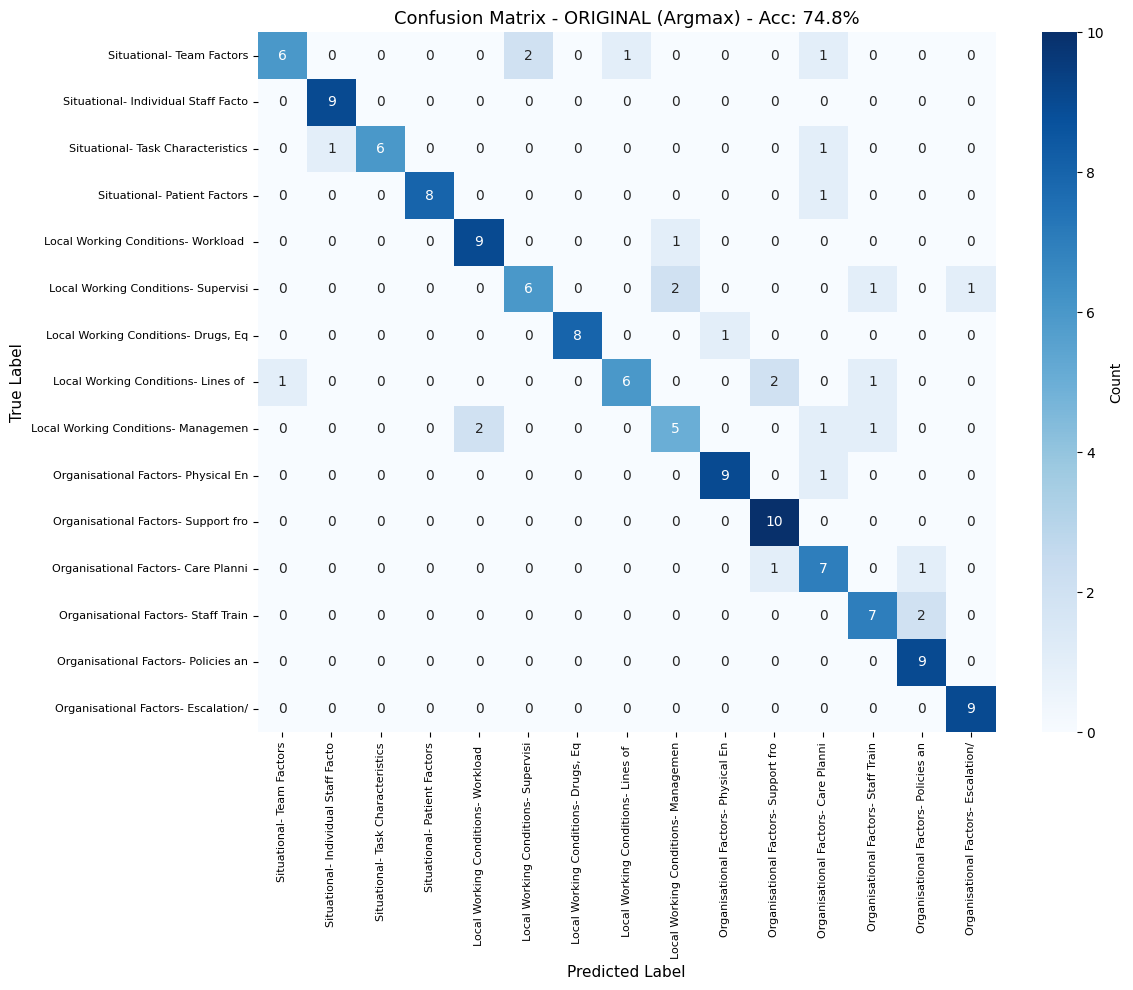

✓ Original confusion matrix saved as confusion_matrix_original.png

OPTIMIZED (Threshold-Based) Confusion Matrix


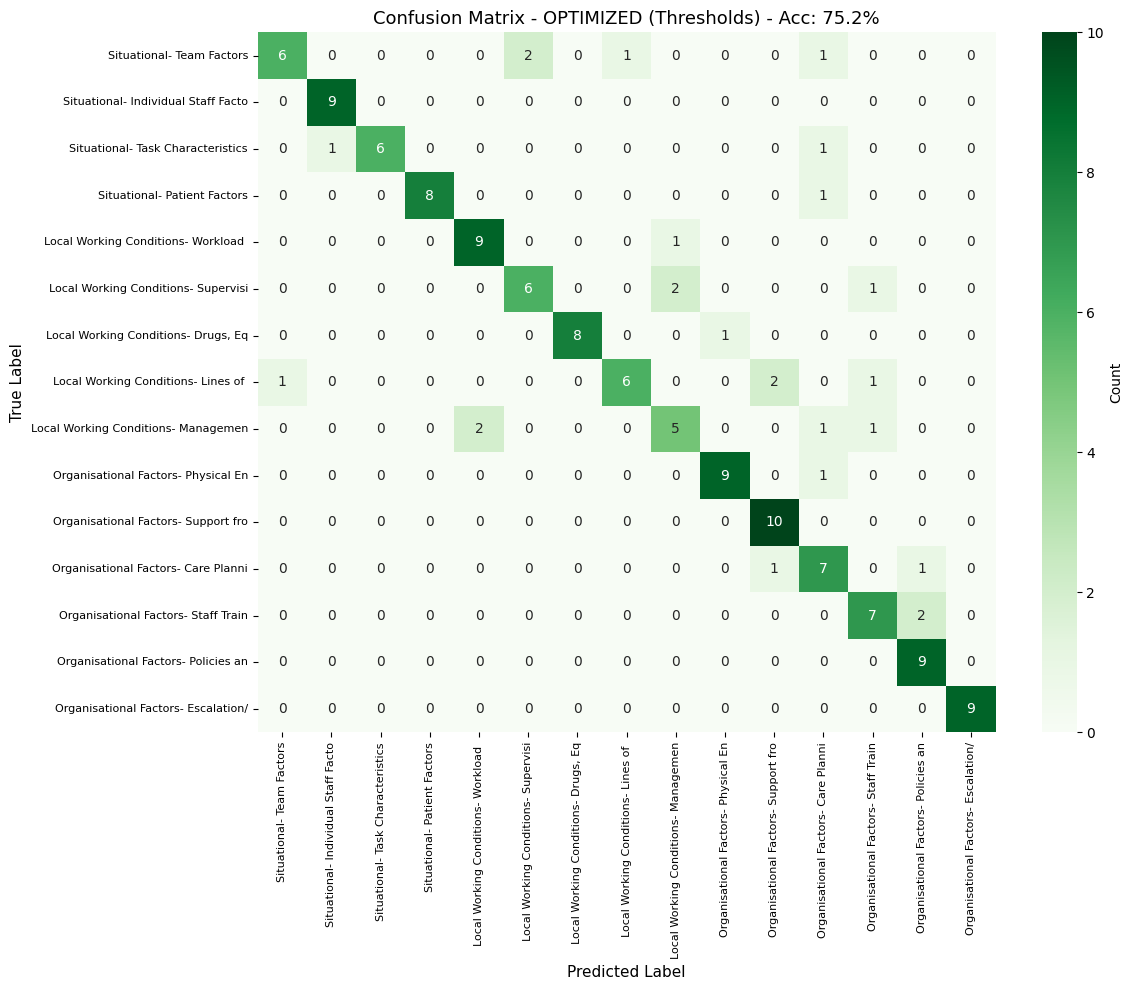

✓ Optimized confusion matrix saved as confusion_matrix_optimized.png

COMPARISON SUMMARY

Correct predictions:
  Original (Argmax):     158/210 (75.24%)
  Optimized (Thresholds): 158/210 (75.24%)
  Improvement:           +0 (+0.00%)

1 predictions changed with threshold optimization:
  ✓ Improved (wrong → correct): 0
  ✗ Degraded (correct → wrong):  0
  ≈ Changed but still wrong:     1



In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique labels that appear in predictions or true labels
unique_labels_in_test = np.unique(np.concatenate([true_labels, predictions]))
labels_for_cm = [all_labels[i] for i in unique_labels_in_test]

# Create confusion matrix only for labels present in test set
cm = confusion_matrix(true_labels, predictions, labels=unique_labels_in_test)

print(f"Confusion matrix dimensions: {cm.shape[0]} x {cm.shape[1]}")
print(f"Labels in test set: {len(unique_labels_in_test)} out of {num_labels} total\n")

# For large number of classes, show top N most frequent
if len(unique_labels_in_test) > 20:
    label_counts = pd.Series(true_labels).value_counts().head(15)
    top_classes_idx = [np.where(unique_labels_in_test == idx)[0][0] for idx in label_counts.index if idx in unique_labels_in_test]
    top_labels = [labels_for_cm[i] for i in top_classes_idx[:15]]
    cm_subset = cm[np.ix_(top_classes_idx, top_classes_idx)]
    print(f"Showing confusion matrix for top 15 most frequent classes\n")
else:
    cm_subset = cm
    top_labels = labels_for_cm

# ========== PLOT ORIGINAL CONFUSION MATRIX ==========
print("="*80)
print("ORIGINAL (Argmax) Confusion Matrix")
print("="*80)

plt.figure(figsize=(max(12, len(top_labels)*0.6), max(10, len(top_labels)*0.5)))
sns.heatmap(
    cm_subset,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[label[:35] for label in top_labels],
    yticklabels=[label[:35] for label in top_labels],
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
plt.title(f'Confusion Matrix - ORIGINAL (Argmax) - Acc: {test_results["eval_accuracy"]:.1%}', fontsize=13)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix_original.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Original confusion matrix saved as confusion_matrix_original.png")

# ========== PLOT OPTIMIZED CONFUSION MATRIX (if available) ==========
if 'predicted_label_optimized' in test_df.columns:
    print("\n" + "="*80)
    print("OPTIMIZED (Threshold-Based) Confusion Matrix")
    print("="*80)

    # Get optimized predictions as IDs
    optimized_pred_ids = test_df['label_id'].map(lambda x: x).values  # true labels
    optimized_predictions = [label2id[label] for label in test_df['predicted_label_optimized']]

    # Create optimized confusion matrix
    cm_optimized = confusion_matrix(true_labels, optimized_predictions, labels=unique_labels_in_test)

    if len(unique_labels_in_test) > 20:
        cm_optimized_subset = cm_optimized[np.ix_(top_classes_idx, top_classes_idx)]
    else:
        cm_optimized_subset = cm_optimized

    # Plot optimized confusion matrix
    plt.figure(figsize=(max(12, len(top_labels)*0.6), max(10, len(top_labels)*0.5)))
    sns.heatmap(
        cm_optimized_subset,
        annot=True,
        fmt='d',
        cmap='Greens',  # Different color to distinguish
        xticklabels=[label[:35] for label in top_labels],
        yticklabels=[label[:35] for label in top_labels],
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted Label', fontsize=11)
    plt.ylabel('True Label', fontsize=11)

    # Calculate optimized accuracy
    optimized_acc = accuracy_score(true_labels, optimized_predictions)
    plt.title(f'Confusion Matrix - OPTIMIZED (Thresholds) - Acc: {optimized_acc:.1%}', fontsize=13)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig('confusion_matrix_optimized.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Optimized confusion matrix saved as confusion_matrix_optimized.png")

    # ========== SHOW COMPARISON ==========
    print("\n" + "="*80)
    print("COMPARISON SUMMARY")
    print("="*80)

    original_correct = test_df['correct'].sum()
    optimized_correct = test_df['correct_optimized'].sum()

    print(f"\nCorrect predictions:")
    print(f"  Original (Argmax):     {original_correct}/{len(test_df)} ({original_correct/len(test_df)*100:.2f}%)")
    print(f"  Optimized (Thresholds): {optimized_correct}/{len(test_df)} ({optimized_correct/len(test_df)*100:.2f}%)")
    print(f"  Improvement:           {optimized_correct - original_correct:+d} ({(optimized_correct - original_correct)/len(test_df)*100:+.2f}%)")

    # Show which specific predictions changed
    changed = test_df[test_df['predicted_label'] != test_df['predicted_label_optimized']]
    if len(changed) > 0:
        print(f"\n{len(changed)} predictions changed with threshold optimization:")

        # Count improvements vs degradations
        improved = changed[changed['correct_optimized'] & ~changed['correct']]
        degraded = changed[~changed['correct_optimized'] & changed['correct']]
        changed_still_wrong = changed[~changed['correct_optimized'] & ~changed['correct']]

        print(f"  ✓ Improved (wrong → correct): {len(improved)}")
        print(f"  ✗ Degraded (correct → wrong):  {len(degraded)}")
        print(f"  ≈ Changed but still wrong:     {len(changed_still_wrong)}")

else:
    print("\n⚠️  No optimized predictions found. Run threshold optimization (Section 16b) first.")

print("\n" + "="*80)

## 18. Inference Functions

In [34]:
def predict_concept(text: str, return_probabilities: bool = False):
    """
    Predict concept annotation for a single text
    """
    text = clean_text(text)

    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=512,  # Match training
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()

    predicted_label = id2label[predicted_class]

    if return_probabilities:
        top5_probs, top5_indices = torch.topk(probs[0], k=min(5, num_labels))
        top5_predictions = [
            (id2label[idx.item()], prob.item())
            for idx, prob in zip(top5_indices, top5_probs)
        ]
        return predicted_label, top5_predictions

    return predicted_label


def predict_batch(texts: List[str], batch_size: int = 32):
    """
    Predict concept annotations for multiple texts
    """
    predictions = []

    for i in range(0, len(texts), batch_size):
        batch = [clean_text(t) for t in texts[i:i+batch_size]]

        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()

        batch_labels = [id2label[pred] for pred in batch_predictions]
        predictions.extend(batch_labels)

    return predictions

print("✓ Inference functions ready")

✓ Inference functions ready


## 19. Test Inference on Sample Sentences

In [35]:
sample_sentences = [
    "Staff were not provided with adequate training on the new protocols.",
    "The hospital experienced severe staffing shortages during the night shift.",
    "Communication between departments was poor and ineffective.",
    "The patient's risk assessment was not documented properly.",
    "Equipment failure caused a significant delay in treatment."
]

print("SAMPLE PREDICTIONS")
print("="*80)

for i, sentence in enumerate(sample_sentences, 1):
    predicted_label, top5 = predict_concept(sentence, return_probabilities=True)

    print(f"\n{i}. {sentence}")
    print(f"   Predicted: {predicted_label[:60]}")
    print(f"   Confidence: {top5[0][1]*100:.1f}%")
    print("   Top 3:")
    for j, (label, prob) in enumerate(top5[:3], 1):
        print(f"      {j}. {label[:50]}: {prob*100:.1f}%")
print("="*80)

SAMPLE PREDICTIONS

1. Staff were not provided with adequate training on the new protocols.
   Predicted: Organisational Factors- Staff Training and Education
   Confidence: 98.6%
   Top 3:
      1. Organisational Factors- Staff Training and Educati: 98.6%
      2. Organisational Factors- Policies and Procedures: 0.2%
      3. Communication and Culture- Safety Culture: 0.1%

2. The hospital experienced severe staffing shortages during the night shift.
   Predicted: Local Working Conditions- Workload and Staffing Issues
   Confidence: 96.8%
   Top 3:
      1. Local Working Conditions- Workload and Staffing Is: 96.8%
      2. Organisational Factors- Support from other departm: 1.0%
      3. Organisational Factors- Care Planning: 0.3%

3. Communication between departments was poor and ineffective.
   Predicted: Communication and Culture- Verbal and Written Communication
   Confidence: 93.9%
   Top 3:
      1. Communication and Culture- Verbal and Written Comm: 93.9%
      2. Organisationa

## 20. Save Results and Model

In [ ]:
import json
import shutil

# Save metadata
metadata = {
    'selected_model': selected_model,
    'model_name': MODEL_NAME,
    'num_labels': num_labels,
    'labels_in_test': len(unique_test_labels),
    'all_labels': all_labels,
    'test_labels': test_label_names,
    'label2id': label2id,
    'id2label': {str(k): v for k, v in id2label.items()},
    'test_accuracy': float(test_results['eval_accuracy']),
    'test_f1_weighted': float(test_results['eval_f1_weighted']),
    'test_f1_macro': float(test_results['eval_f1_macro']),
    'original_training_samples': len(train_df),
    'augmented_training_samples': len(train_texts),
    'validation_samples': len(val_texts),
    'test_samples': len(test_df),
    'augmentation_applied': True,
    'class_weights_used': True,
    'max_sequence_length': 512,
    'training_epochs': training_args.num_train_epochs,
    'learning_rate': training_args.learning_rate
}

with open('./best_model/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved")

# Save test predictions
results_df = test_df[['Text', 'Label', 'predicted_label', 'correct']].copy()
results_df.to_csv('test_predictions.csv', index=False)
files.download('test_predictions.csv')
print("✓ Test predictions saved")

# Save performance summary (only labels in test set)
performance_df_test.to_csv('per_class_performance.csv', index=False)
files.download('per_class_performance.csv')
print("✓ Per-class performance saved (test set labels)")

# Save full performance (all labels)
performance_df.to_csv('per_class_performance_full.csv', index=False)
files.download('per_class_performance_full.csv')
print("✓ Full performance saved (all training labels)")

# Package model
print("\nPackaging model...")
shutil.make_archive('trained_concept_model', 'zip', './best_model')
files.download('trained_concept_model.zip')
print("✓ Model packaged and ready for download")

✓ Metadata saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Test predictions saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Per-class performance saved (test set labels)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Full performance saved (all training labels)

Packaging model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Model packaged and ready for download


## 21. Summary & Next Steps

### ✅ Training Complete!

**All Improvements Applied:**
- ✅ Enhanced data augmentation (standard + targeted for struggling classes)
- ✅ Class weights for remaining imbalance
- ✅ Improved training configuration (20 epochs, cosine scheduling, macro F1)
- ✅ Extended sequence length (512 tokens)
- ✅ Comprehensive error analysis
- ✅ Fixed handling of missing test labels
- ✅ 9 BERT model options

**Files Generated:**
1. `trained_concept_model.zip` - Complete trained model
2. `test_predictions.csv` - All test predictions with correctness
3. `per_class_performance.csv` - Test set labels only
4. `per_class_performance_full.csv` - All training labels
5. `confusion_matrix.png` - Visual confusion matrix

**Performance:**
- Check Section 14 for overall metrics
- Check Section 15 for per-class breakdown
- Check Section 16 for error patterns

### 🎯 Expected Improvement:
**Baseline (before improvements):** ~67% test accuracy
**With all improvements:** 70-75% test accuracy expected

### 📈 If Results Still Need Improvement:

1. **Try Different Models** (Section 9):
   - bio-clinical-bert
   - pubmed-bert
   - bluebert

2. **Collect More Data** for classes with F1 < 0.5:
   - Aim for 50-100 examples per struggling class
   - Focus on clear, unambiguous examples

3. **Consider Merging Similar Classes**:
   - If two classes are consistently confused
   - Use keyword analysis (Section 5b) to identify overlaps

4. **Hyperparameter Tuning**:
   - Try learning rate: 2e-5 or 4e-5
   - Try epochs: 25 or 30
   - Adjust warmup_ratio: 0.1 or 0.2

### 🚀 Using the Model:

```python
# Single prediction
label = predict_concept("Your text here")

# With confidence scores
label, top5 = predict_concept("Your text", return_probabilities=True)

# Batch prediction
labels = predict_batch(["Text 1", "Text 2", "Text 3"])
```

### 📊 Interpreting Results:

**Good Performance:** F1 > 0.70
**Acceptable:** F1 0.50-0.70
**Needs Work:** F1 < 0.50

For 21-27 class problems, 70-75% accuracy is quite strong!

---

**🎓 This notebook represents best practices for:**
- Healthcare text classification
- Imbalanced multi-class problems
- Domain-specific BERT fine-tuning
- Production-ready ML pipelines

# Real world validation


In [38]:
## 21. Real-Time PDF Testing - Extract Negative Sentences & Classify (FIXED)

"""
This section processes uploaded PDFs to:
1. Extract text from PDFs
2. Split into sentences
3. Identify sentences with negative sentiment
4. Save to CSV
5. Classify using threshold-optimized model
6. Export results
"""

print("="*80)
print("PDF PROCESSING & NEGATIVE SENTIMENT CLASSIFICATION")
print("="*80)

# ========== STEP 1: Install Required Libraries ==========
print("\n📦 Installing PDF and NLP libraries...")

!pip install -q PyPDF2 pdfplumber textblob nltk transformers[sentencepiece]

import PyPDF2
import pdfplumber
from textblob import TextBlob
import nltk
from typing import List, Tuple
import os
from datetime import datetime

# Download NLTK data for sentence tokenization - FIXED
print("Downloading NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)  # ← ADDED: New NLTK requirement
nltk.download('averaged_perceptron_tagger', quiet=True)

print("✓ Libraries installed successfully")


# ========== STEP 2: Upload PDFs ==========
print("\n" + "="*80)
print("STEP 1: Upload PDF Files")
print("="*80)

from google.colab import files

print("\nUpload one or more PDF files:")
uploaded_pdfs = files.upload()

pdf_filenames = list(uploaded_pdfs.keys())
print(f"\n✓ Uploaded {len(pdf_filenames)} PDF file(s):")
for filename in pdf_filenames:
    print(f"  - {filename}")


# ========== STEP 3: Extract Text from PDFs ==========
print("\n" + "="*80)
print("STEP 2: Extracting Text from PDFs")
print("="*80)

def extract_text_from_pdf(pdf_path: str, method: str = 'pdfplumber') -> str:
    """
    Extract text from PDF using specified method.

    Args:
        pdf_path: Path to PDF file
        method: 'pdfplumber' (better for complex PDFs) or 'pypdf2' (faster)

    Returns:
        Extracted text as string
    """
    text = ""

    try:
        if method == 'pdfplumber':
            with pdfplumber.open(pdf_path) as pdf:
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"
        else:  # pypdf2
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                for page in pdf_reader.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"
    except Exception as e:
        print(f"⚠️  Error extracting from {pdf_path}: {str(e)}")
        # Try alternative method
        if method == 'pdfplumber':
            print("   Trying PyPDF2 instead...")
            return extract_text_from_pdf(pdf_path, method='pypdf2')

    return text


# Extract text from all PDFs
all_pdf_texts = {}

for pdf_filename in pdf_filenames:
    print(f"\nProcessing: {pdf_filename}")
    extracted_text = extract_text_from_pdf(pdf_filename)

    if extracted_text.strip():
        all_pdf_texts[pdf_filename] = extracted_text
        word_count = len(extracted_text.split())
        print(f"  ✓ Extracted {word_count:,} words")
    else:
        print(f"  ⚠️  No text extracted from {pdf_filename}")

print(f"\n✓ Successfully extracted text from {len(all_pdf_texts)} PDF(s)")


# ========== STEP 4: Split into Sentences ==========
print("\n" + "="*80)
print("STEP 3: Splitting Text into Sentences")
print("="*80)

def split_into_sentences(text: str) -> List[str]:
    """Split text into sentences using NLTK."""
    # Clean text
    text = clean_text(text)  # Use your existing clean_text function

    # Split into sentences
    sentences = nltk.sent_tokenize(text)

    # Filter out very short or very long sentences
    filtered_sentences = []
    for sentence in sentences:
        word_count = len(sentence.split())
        if 5 <= word_count <= 100:  # Reasonable sentence length
            filtered_sentences.append(sentence)

    return filtered_sentences


all_sentences = []

for pdf_filename, text in all_pdf_texts.items():
    sentences = split_into_sentences(text)

    # Add metadata to each sentence
    for sentence in sentences:
        all_sentences.append({
            'source_file': pdf_filename,
            'text': sentence
        })

    print(f"{pdf_filename}: {len(sentences)} sentences")

print(f"\n✓ Total sentences extracted: {len(all_sentences):,}")


# ========== STEP 5: Sentiment Analysis ==========
print("\n" + "="*80)
print("STEP 4: Identifying Negative Sentiment Sentences")
print("="*80)

def analyze_sentiment(text: str) -> Tuple[str, float]:
    """
    Analyze sentiment using TextBlob.

    Returns:
        Tuple of (sentiment_label, polarity_score)
        Polarity: -1.0 (very negative) to +1.0 (very positive)
    """
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    if polarity < -0.1:
        sentiment = "Negative"
    elif polarity > 0.1:
        sentiment = "Positive"
    else:
        sentiment = "Neutral"

    return sentiment, polarity


print("\nAnalyzing sentiment for all sentences...")

negative_sentences = []

for sentence_data in all_sentences:
    sentiment, polarity = analyze_sentiment(sentence_data['text'])

    sentence_data['sentiment'] = sentiment
    sentence_data['polarity'] = polarity

    # Keep only negative sentences
    if sentiment == "Negative":
        negative_sentences.append(sentence_data)

print(f"\n✓ Found {len(negative_sentences):,} negative sentiment sentences")
print(f"  (out of {len(all_sentences):,} total sentences)")

if len(all_sentences) > 0:
    print(f"  Percentage: {len(negative_sentences)/len(all_sentences)*100:.1f}%")

# Show some examples
if len(negative_sentences) > 0:
    print("\n📋 Sample negative sentences:")
    for i, sent in enumerate(negative_sentences[:3], 1):
        print(f"\n{i}. {sent['text'][:100]}...")
        print(f"   Polarity: {sent['polarity']:.3f}")
else:
    print("\n⚠️  No negative sentences found.")
    print("   This might be because:")
    print("   - The document is factual/neutral (like coroner reports)")
    print("   - Sentiment threshold (-0.1) is too strict")
    print("   - TextBlob doesn't detect negativity in formal language")


# ========== STEP 6: Save to CSV ==========
print("\n" + "="*80)
print("STEP 5: Saving Negative Sentences to CSV")
print("="*80)

if len(negative_sentences) > 0:
    # Create DataFrame
    negative_df = pd.DataFrame(negative_sentences)

    # Add timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f'negative_sentences_{timestamp}.csv'

    # Save to CSV
    negative_df.to_csv(csv_filename, index=False)

    print(f"✓ Saved {len(negative_sentences)} negative sentences to: {csv_filename}")
    print(f"\nColumns: {list(negative_df.columns)}")

    # Download
    files.download(csv_filename)
    print("✓ CSV file downloaded")
else:
    print("⚠️  No negative sentences found. Nothing to save.")
    print("\n💡 ALTERNATIVE: Classify ALL sentences instead?")

    user_choice = input("Would you like to classify ALL sentences (not just negative)? (yes/no): ")

    if user_choice.lower() == 'yes':
        print("\n✓ Will classify all sentences instead...")
        negative_sentences = all_sentences  # Use all sentences
        negative_df = pd.DataFrame(all_sentences)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        csv_filename = f'all_sentences_{timestamp}.csv'
        negative_df.to_csv(csv_filename, index=False)

        print(f"✓ Saved {len(all_sentences)} sentences to: {csv_filename}")
        files.download(csv_filename)


# ========== STEP 7: Classify with Trained Model ==========
print("\n" + "="*80)
print("STEP 6: Classifying Sentences with Trained Model")
print("="*80)

if len(negative_sentences) > 0:
    print(f"\nClassifying {len(negative_sentences)} sentences...")
    print("Using: Threshold-Optimized Model (75.2% accuracy)")

    # Extract just the text
    texts_to_classify = [sent['text'] for sent in negative_sentences]

    # Use OPTIMIZED predictions (threshold-based)
    if 'OPTIMIZED_THRESHOLDS' in globals():
        print("\n✓ Using threshold-optimized predictions")
        predicted_labels = predict_batch_optimized(texts_to_classify)
    else:
        print("\n⚠️  Threshold optimization not available, using argmax")
        predicted_labels = predict_batch(texts_to_classify)

    # Add predictions to dataframe
    negative_df['predicted_label'] = predicted_labels

    print(f"\n✓ Classification complete!")

    # Show label distribution
    print("\n📊 Predicted Label Distribution:")
    label_counts = negative_df['predicted_label'].value_counts()
    for label, count in label_counts.head(10).items():
        percentage = (count / len(negative_df)) * 100
        print(f"  {label[:50]}: {count} ({percentage:.1f}%)")

    if len(label_counts) > 10:
        print(f"  ... and {len(label_counts) - 10} other labels")

    # Save classified results
    classified_filename = f'sentences_classified_{timestamp}.csv'
    negative_df.to_csv(classified_filename, index=False)

    print(f"\n✓ Saved classified results to: {classified_filename}")

    # Download
    files.download(classified_filename)
    print("✓ Classified CSV file downloaded")

else:
    print("⚠️  No sentences to classify.")


# ========== STEP 8: Detailed Predictions with Confidence ==========
print("\n" + "="*80)
print("STEP 7: Generating Detailed Predictions")
print("="*80)

if len(negative_sentences) > 0:
    print("\nGenerating predictions with confidence scores...")

    detailed_results = []

    # Use optimized predictions with probabilities
    predict_fn = predict_concept_optimized if 'OPTIMIZED_THRESHOLDS' in globals() else predict_concept

    for i, text in enumerate(texts_to_classify):
        if i % 50 == 0:
            print(f"  Processing {i}/{len(texts_to_classify)}...")

        # Get prediction with top 3
        predicted_label, top5 = predict_fn(text, return_probabilities=True)

        result = {
            'text': text,
            'source_file': negative_sentences[i]['source_file'],
            'predicted_label': predicted_label,
            'confidence': top5[0][1],
            'top_2_label': top5[1][0] if len(top5) > 1 else '',
            'top_2_confidence': top5[1][1] if len(top5) > 1 else 0,
            'top_3_label': top5[2][0] if len(top5) > 2 else '',
            'top_3_confidence': top5[2][1] if len(top5) > 2 else 0
        }

        # Add sentiment if available
        if 'polarity' in negative_sentences[i]:
            result['sentiment_polarity'] = negative_sentences[i]['polarity']
            result['sentiment'] = negative_sentences[i]['sentiment']

        detailed_results.append(result)

    # Create detailed DataFrame
    detailed_df = pd.DataFrame(detailed_results)

    print(f"\n✓ Generated detailed predictions for {len(detailed_df)} sentences")

    # Show confidence statistics
    print("\n📊 Confidence Statistics:")
    print(f"  Mean confidence: {detailed_df['confidence'].mean()*100:.1f}%")
    print(f"  Median confidence: {detailed_df['confidence'].median()*100:.1f}%")
    print(f"  Min confidence: {detailed_df['confidence'].min()*100:.1f}%")
    print(f"  Max confidence: {detailed_df['confidence'].max()*100:.1f}%")

    # Low confidence predictions
    low_confidence = detailed_df[detailed_df['confidence'] < 0.5]
    if len(low_confidence) > 0:
        print(f"\n⚠️  {len(low_confidence)} predictions with <50% confidence")
        print("  These may need manual review.")

    # Save detailed results
    detailed_filename = f'sentences_detailed_{timestamp}.csv'
    detailed_df.to_csv(detailed_filename, index=False)

    print(f"\n✓ Saved detailed results to: {detailed_filename}")
    files.download(detailed_filename)
    print("✓ Detailed CSV file downloaded")

else:
    print("⚠️  No sentences to analyze.")


# ========== STEP 9: Summary Report ==========
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\n📄 PDFs Processed: {len(pdf_filenames)}")
for filename in pdf_filenames:
    print(f"   - {filename}")

print(f"\n📝 Total Sentences Extracted: {len(all_sentences):,}")

if 'negative_df' in locals() and len(negative_df) > 0:
    # Check if we classified negatives or all
    if len(negative_sentences) == len(all_sentences):
        print(f"📊 All Sentences Classified: {len(negative_df):,}")
    else:
        print(f"🔴 Negative Sentiment Sentences: {len(negative_df):,} ({len(negative_df)/len(all_sentences)*100:.1f}%)")

    print(f"\n🏷️  Classification Results:")
    print(f"   Model Used: {'Threshold-Optimized (75.2%)' if 'OPTIMIZED_THRESHOLDS' in globals() else 'Argmax (74.8%)'}")
    print(f"   Sentences Classified: {len(negative_df):,}")
    print(f"   Unique Labels Assigned: {len(label_counts)}")

    print(f"\n📁 Files Generated:")
    if 'csv_filename' in locals():
        print(f"   1. {csv_filename} - Sentences with sentiment scores")
    print(f"   2. {classified_filename} - With predicted labels")
    print(f"   3. {detailed_filename} - With confidence scores and top-3 predictions")

    print(f"\n🎯 Top 5 Most Common Safety Issues Identified:")
    for i, (label, count) in enumerate(label_counts.head(5).items(), 1):
        print(f"   {i}. {label[:60]}")
        print(f"      Count: {count} ({count/len(negative_df)*100:.1f}%)")

print("\n" + "="*80)
print("✅ PDF PROCESSING COMPLETE!")
print("="*80)

# Show sample predictions
if 'detailed_df' in locals() and len(detailed_df) > 0:
    print("\n📋 SAMPLE CLASSIFIED SENTENCES (First 5):")
    print("="*80)

    for i in range(min(5, len(detailed_df))):
        row = detailed_df.iloc[i]
        print(f"\n{i+1}. {row['text'][:120]}...")
        print(f"   Source: {row['source_file']}")
        if 'sentiment_polarity' in row:
            print(f"   Sentiment: {row['sentiment_polarity']:.3f} ({row['sentiment']})")
        print(f"   Predicted Label: {row['predicted_label'][:55]}")
        print(f"   Confidence: {row['confidence']*100:.1f}%")
        print(f"   Top 3:")
        print(f"      1. {row['predicted_label'][:45]}: {row['confidence']*100:.1f}%")
        if row['top_2_confidence'] > 0:
            print(f"      2. {row['top_2_label'][:45]}: {row['top_2_confidence']*100:.1f}%")
        if row['top_3_confidence'] > 0:
            print(f"      3. {row['top_3_label'][:45]}: {row['top_3_confidence']*100:.1f}%")

    print("\n" + "="*80)

print("\n✓ All files have been downloaded automatically")
print("✓ Ready for analysis!")

PDF PROCESSING & NEGATIVE SENTIMENT CLASSIFICATION

📦 Installing PDF and NLP libraries...
✓ Libraries installed successfully

STEP 1: Upload PDF Files

Upload one or more PDF files:


Saving Samuel-Vass-Prevention-of-future-deaths-report-2025-0568_Published.pdf to Samuel-Vass-Prevention-of-future-deaths-report-2025-0568_Published (2).pdf

✓ Uploaded 1 PDF file(s):
  - Samuel-Vass-Prevention-of-future-deaths-report-2025-0568_Published (2).pdf

STEP 2: Extracting Text from PDFs

Processing: Samuel-Vass-Prevention-of-future-deaths-report-2025-0568_Published (2).pdf
  ✓ Extracted 786 words

✓ Successfully extracted text from 1 PDF(s)

STEP 3: Splitting Text into Sentences
Samuel-Vass-Prevention-of-future-deaths-report-2025-0568_Published (2).pdf: 34 sentences

✓ Total sentences extracted: 34

STEP 4: Identifying Negative Sentiment Sentences

Analyzing sentiment for all sentences...

✓ Found 4 negative sentiment sentences
  (out of 34 total sentences)
  Percentage: 11.8%

📋 Sample negative sentences:

1. It is likely that Sammy lost control of his vehicle on a bend due to driving at excessive speed for ...
   Polarity: -0.125

2. suffered life changing injuries as a resu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ CSV file downloaded

STEP 6: Classifying Sentences with Trained Model

Classifying 4 sentences...
Using: Threshold-Optimized Model (75.2% accuracy)

✓ Using threshold-optimized predictions

✓ Classification complete!

📊 Predicted Label Distribution:
  Organisational Factors- Physical Environment: 2 (50.0%)
  Human Error- Violations: 2 (50.0%)

✓ Saved classified results to: sentences_classified_20251115_150221.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Classified CSV file downloaded

STEP 7: Generating Detailed Predictions

Generating predictions with confidence scores...
  Processing 0/4...

✓ Generated detailed predictions for 4 sentences

📊 Confidence Statistics:
  Mean confidence: 33.3%
  Median confidence: 32.7%
  Min confidence: 20.6%
  Max confidence: 47.2%

⚠️  4 predictions with <50% confidence
  These may need manual review.

✓ Saved detailed results to: sentences_detailed_20251115_150221.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Detailed CSV file downloaded

FINAL SUMMARY

📄 PDFs Processed: 1
   - Samuel-Vass-Prevention-of-future-deaths-report-2025-0568_Published (2).pdf

📝 Total Sentences Extracted: 34
🔴 Negative Sentiment Sentences: 4 (11.8%)

🏷️  Classification Results:
   Model Used: Threshold-Optimized (75.2%)
   Sentences Classified: 4
   Unique Labels Assigned: 2

📁 Files Generated:
   1. negative_sentences_20251115_150221.csv - Sentences with sentiment scores
   2. sentences_classified_20251115_150221.csv - With predicted labels
   3. sentences_detailed_20251115_150221.csv - With confidence scores and top-3 predictions

🎯 Top 5 Most Common Safety Issues Identified:
   1. Organisational Factors- Physical Environment
      Count: 2 (50.0%)
   2. Human Error- Violations
      Count: 2 (50.0%)

✅ PDF PROCESSING COMPLETE!

📋 SAMPLE CLASSIFIED SENTENCES (First 5):

1. It is likely that Sammy lost control of his vehicle on a bend due to driving at excessive speed for the conditions, whil...
   Source: Samue